In [86]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scipy.sparse as sp
import scanpy as sc
import anndata as ad

In [87]:
path_main = '../../data/with_disease_data'
healthy = '../../data/only_healthy_data'
figure_outputs = '../../figures/exp04/1_figures'

In [88]:
healthy_raw = pd.read_csv(f'{healthy}/healthy_only_pathway_abundance_raw_counts.txt', sep='\t', index_col=0, header=0)
crc_raw = pd.read_csv(f'{path_main}/crc_pathway_abundance_raw_counts.txt', sep='\t', index_col=0, header=0)
ibd_t2d_raw = pd.read_csv(f'{path_main}/ibd_t2d_pathway_abundance_raw_counts.txt', sep='\t', index_col=0, header=0)
meta_raw = pd.read_csv(f'{path_main}/healthy_crc_ibd_t2d_samples_metadata.csv', sep=',', index_col=0, header=0)

/tmp/ipykernel_633868/1048200839.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

In [105]:
temp = pd.merge(healthy_raw, crc_raw, left_index=True, right_index=True,how='outer')
all_raw = pd.merge(temp, ibd_t2d_raw, left_index=True, right_index=True,how='outer')

In [106]:
# fixing names from initial processing
def process_column_name(col):
    if col.startswith('EGAR'):
        parts = col.split('_')
        if len(parts) > 1:
            return parts[1].replace('LL', '')
    return col  
def remove_i_j(name):
    if isinstance(name, str):
        if name.startswith('i'):
            name = name[1:]
        if name.startswith('j'):
            name = name[1:]
        if name.startswith('IBD_'):
            name = name[4:]
        if name.startswith('crc'):
            name = name[3:]
    return name
all_raw.columns = [process_column_name(col) for col in all_raw.columns] # sample names fixing
all_raw.loc['study'] = all_raw.loc['study'].apply(remove_i_j)
all_raw = all_raw.loc[:, all_raw.columns.isin(meta_raw.index)] # filtering samples not supposed to be processed
all_raw.fillna(0, inplace=True)

In [107]:
all_raw = all_raw.drop(labels=['UNMAPPED', 'UNINTEGRATED', 'UNINTEGRATED|unclassified']) # drop unclassified data
all_raw = all_raw[~(all_raw.index.str.contains('g_') | 
          all_raw.index.str.contains('s_') | 
          all_raw.index.str.contains('UNINTEGRATED') | 
          all_raw.index.str.contains('unclassified'))]
print(all_raw.shape)

#remove 0 rows and columns 
all_raw = all_raw[(all_raw != 0).any(axis=1)]
all_raw = all_raw.loc[:, (all_raw != 0).any()]
print(all_raw.shape)
# Extract the last row as metadata
row_to_update = all_raw.loc['study'].apply(lambda x: 'EGAR' if x.startswith('EGAR') else x)
all_raw.loc['study'] = row_to_update
metadata_row = all_raw.iloc[-1]
metadata_row = pd.DataFrame(metadata_row.transpose())

# Update the study column only for missing values
matching_indices = meta_raw.index.intersection(metadata_row.index)
for idx in matching_indices:
    if pd.isna(meta_raw.at[idx, "study"]):  # Check if the value is missing
        meta_raw.at[idx, "study"] = metadata_row.at[idx, "study"]

all_raw = all_raw.drop(index=all_raw.index[-1]) # drop study rows
all_raw = all_raw.apply(pd.to_numeric, errors='coerce')

(757, 12489)
(757, 12489)


In [108]:
meta_raw = meta_raw[meta_raw.antibiotics_current_use != 'yes']
meta_raw.loc[(meta_raw['country'] == 'California'), 
    'country'
] = 'United States'
meta_raw.loc[
    meta_raw['sex'] == 'female', 
    'sex'
] = 'Female'

meta_raw.loc[
    meta_raw['sex'] == 'male', 
    'sex'
] = 'Male'
meta_raw.loc[(meta_raw['study'] == 'WGM'), 
    'disease'
] = 'healthy'

meta_raw.disease.value_counts()

disease
healthy    11309
T2D          515
IBD          436
CRC          229
Name: count, dtype: int64

In [109]:
# Convert the DataFrame to an AnnData object
adata = ad.AnnData(all_raw.transpose())
adata.X = adata.X.astype(float)
adata.X = sp.csr_matrix(adata.X)
# Add the metadata row to .obs
adata.obs = meta_raw

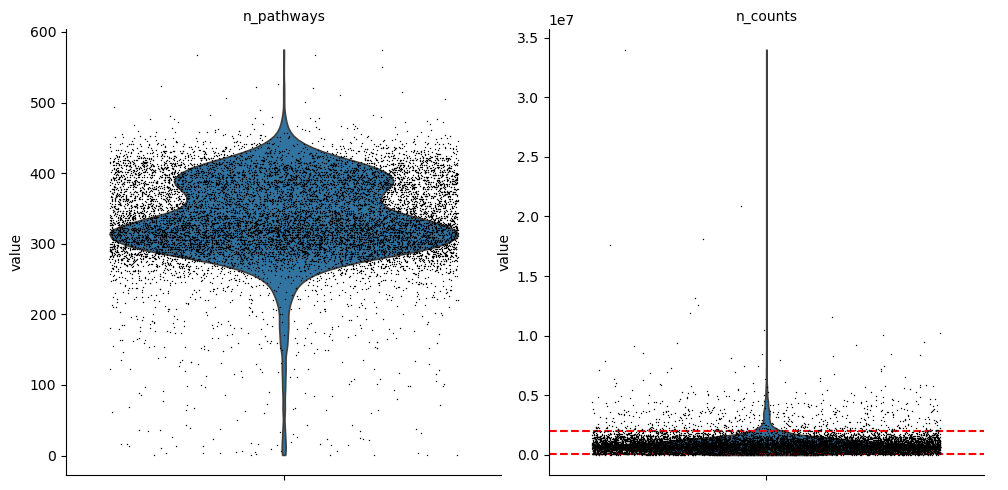

In [110]:
# Filter out genes with non-zero expression in less than 1 cells
sc.pp.filter_genes(adata, min_cells=1)
# filter out cells that express no genes
sc.pp.filter_cells(adata, min_genes=1)
# Calculate total number of counts and total number of genes
adata.obs["n_counts"] = adata.X.sum(axis=1) # number of expressions of a row
adata.obs["n_pathways"] = (adata.X>0).sum(axis=1) # count the number of non-zero cells in a row
# Plot the violin plots and retrieve the FacetGrid object
grid = sc.pl.violin(
    adata,
    ['n_pathways', 'n_counts'],
    jitter=0.4,
    multi_panel=True,
    show=False
)
# Flatten the axes for easy indexing
axes = grid.axes.flatten()
# Add dashed lines at 100k and 2M on the 'n_counts' plot
axes[1].axhline(y=1e5, linestyle='--', color='red')
axes[1].axhline(y=2e6, linestyle='--', color='red')
# Display the plot
plt.show()

In [111]:
all_raw.to_csv(f'{path_main}/with_disease_classified_raw_pathways_counts.csv', sep=',', index=True, header=True) 

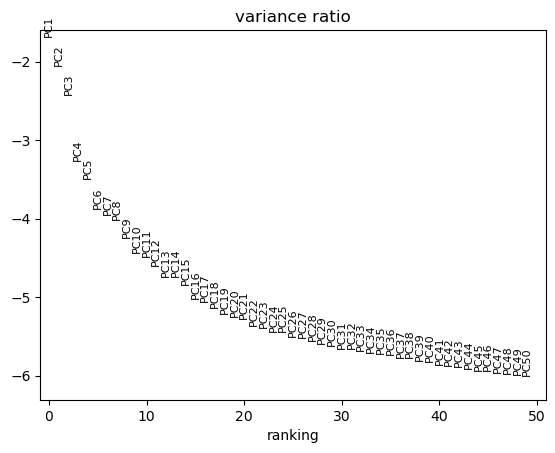

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


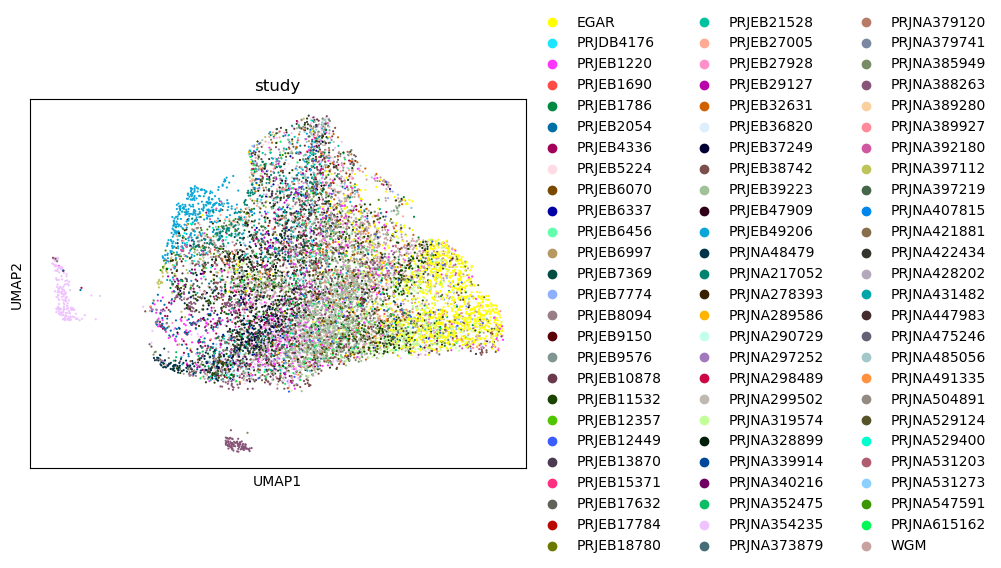

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


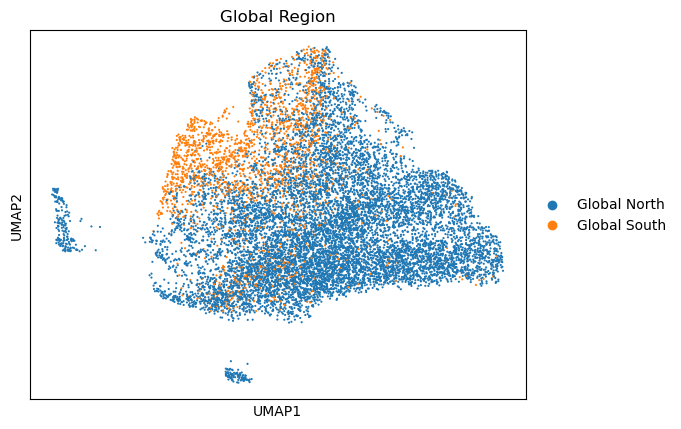

/data/lab_vm/campervans/mmeawad_test/anaconda/test4.2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


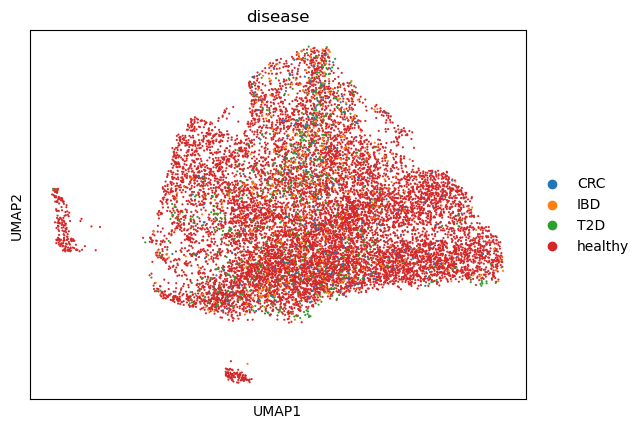

In [112]:
adata_original = adata.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

sc.pp.neighbors(adata, n_pcs=50, n_neighbors=15)
sc.tl.umap(adata)
obs_list = ['study', 'Global Region', 'disease']
for i in obs_list:
    sc.pl.umap(adata, color=i)

# sample and pathways filtering 

In [113]:
# filtering samples with >= 100000 and <= 2000000 counts
df_filtered = all_raw.loc[:, (all_raw.sum() >= 100000) & (all_raw.sum() <= 2000000)]

# filtering paths
threshold_percentage = 10
threshold_value = len(df_filtered.columns) * (threshold_percentage / 100)
df_filtered = df_filtered[df_filtered[df_filtered != 0].count(axis=1) >= threshold_value]

common_columns = df_filtered.columns.intersection(meta_raw.transpose().columns)
meta_filtered_study = meta_raw.transpose()[common_columns]
meta_filtered_study = meta_filtered_study.transpose()

# filtering for studies with >30 samples 
study_sample_counts = meta_filtered_study['study'].value_counts()
valid_studies = study_sample_counts[study_sample_counts >= 30].index
meta_filtered_study = meta_filtered_study[meta_filtered_study['study'].isin(valid_studies)]
meta_filtered_study = meta_filtered_study[meta_filtered_study['study'].notna()]
meta_filtered_study_filtered = meta_filtered_study[meta_filtered_study['study'] != 'NA']
df_filtered = df_filtered.loc[:, df_filtered.columns.isin(meta_filtered_study_filtered.index)]
df_filtered.shape

(437, 10878)

In [114]:
# Update the column names to add 'EGAR' if they start with '900' for R processing
df_filtered.columns = ['EGAR' + col if col.startswith('900') else col for col in df_filtered.columns]
df_filtered.columns = ['EGAR' + col if col.startswith('200') else col for col in df_filtered.columns]
# Update the column names to add 'EGAR' if they start with '900' for R processing
meta_filtered_study.index = ['EGAR' + str(idx) if str(idx).startswith('900') else str(idx) for idx in meta_filtered_study.index]
meta_filtered_study.index = ['EGAR' + str(idx) if str(idx).startswith('200') else str(idx) for idx in meta_filtered_study.index]

In [116]:
meta_filtered_study.to_csv(f'{path_main}/filtered_paths_with_disease_samples_metadata.csv', sep=',', index=True, header=True) 
df_filtered.to_csv(f'{path_main}/filtered_paths_with_disease_samples_pathway_counts.csv', sep=',', index=True, header=True) 